In [1]:
%matplotlib inline
from obspy import read, UTCDateTime as UTC
from obspy.signal.cross_correlation import correlation_detector
import obspy
import io
import matplotlib.pyplot as plt
import helpers
import numpy as np
import pandas as pd

from obspy.signal import trigger
from obspy.signal import filter

from datetime import datetime

from multiprocessing import Pool
import glob

import tempmatch as tm

In [2]:
datafiles2019 = glob.glob('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.*')
datafiles2020 = glob.glob('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2020.*')
datafiles = datafiles2019 + datafiles2020


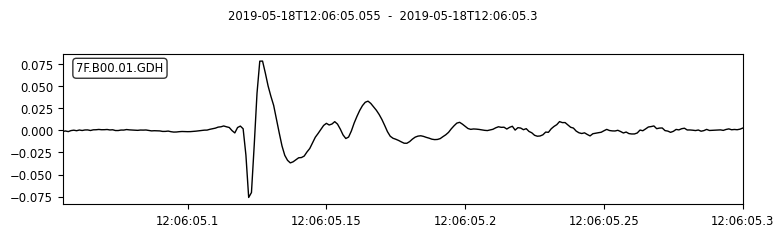

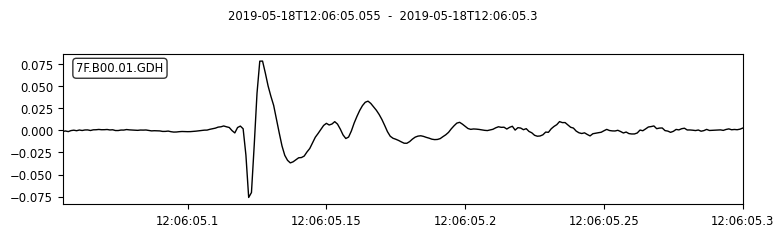

In [3]:
tm.make_template('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138' , '2019-05-18T12:06:05.055Z', '2019-05-18T12:06:05.3Z').plot()

In [4]:
templates = [
    tm.make_template('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138', '2019-05-18T11:57:41.507000Z', '2019-05-18T11:57:41.782000Z')    
    ,tm.make_template('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.274', '2019-10-01T12:32:11.92Z', '2019-10-01T12:32:12.13Z')
#     ,tm.make_template('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.274', '2019-10-01T12:32:11.85Z', '2019-10-01T12:32:12.13Z')
    ,tm.make_template('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138' , '2019-05-18T12:06:05.1Z', '2019-05-18T12:06:05.3Z')
    ,tm.make_template('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138' , '2019-05-18T12:06:22.65Z', '2019-05-18T12:06:22.939Z')
]

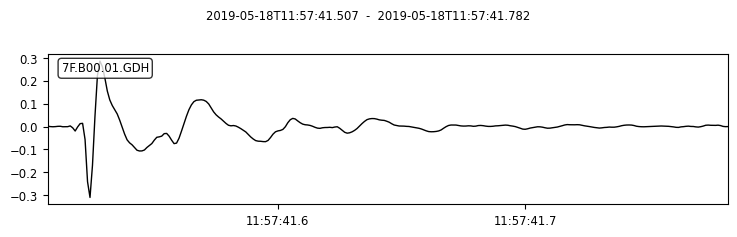

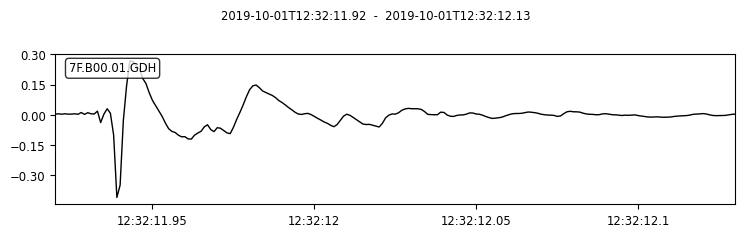

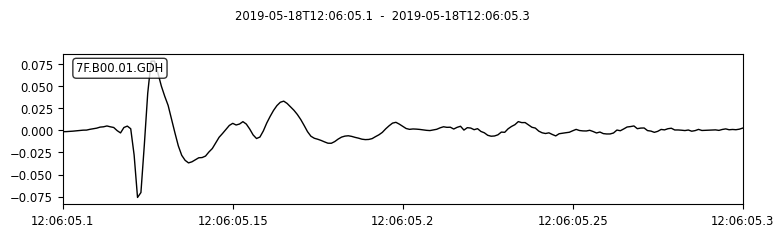

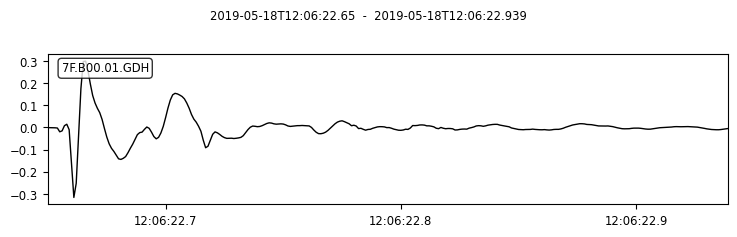

In [5]:
# _ = templates[0].plot()
# _ = templates[1].plot()
# _ = templates[2].plot()
for t in templates:
    t.plot()

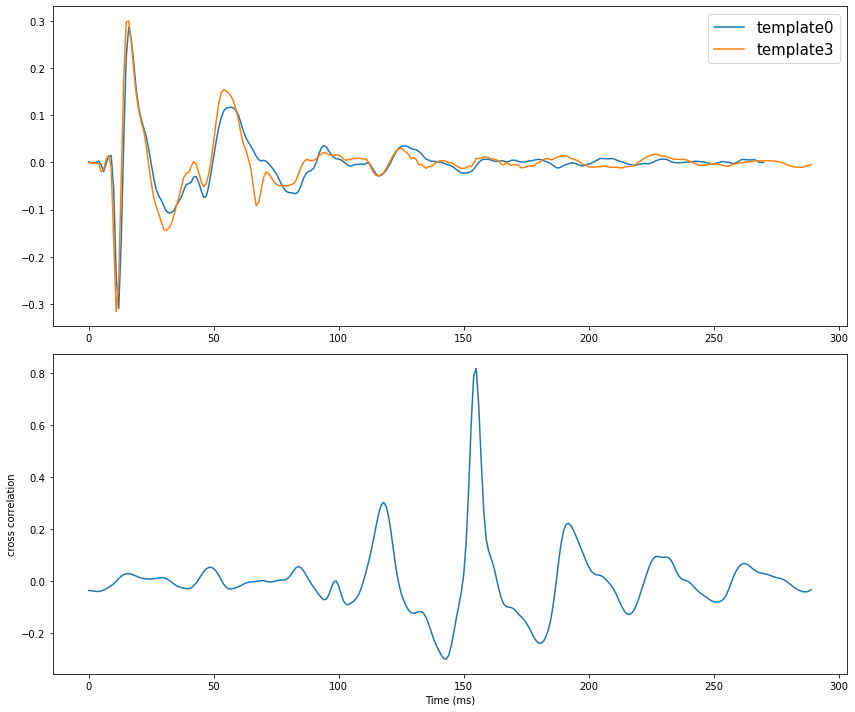

In [6]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax.plot(templates[0][0].data[5:])
ax.plot(templates[3][0].data)

cc = np.correlate(templates[0][0].data[5:], templates[3][0].data, 'same')
ax2.plot(cc)

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('cross correlation')
ax.legend(['template0', 'template3'], fontsize=15)

fig.tight_layout()

In [7]:
day138 = tm.digest_data('/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138')

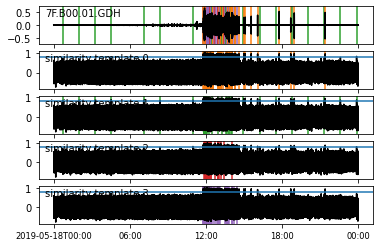

In [8]:
height = 0.8
# distance = 3
distance = 1.1
detections, sims = correlation_detector(stream=day138
#                                        ,templates=templates[::-1]
                                       ,templates=templates
                                       ,heights=height
                                       ,distance=distance
                                       ,plot=day138)

In [9]:
df = pd.DataFrame(detections)
df['ones'] = 1
df['cumevents'] = df.ones.cumsum()
df['time'] = pd.to_datetime(df['time'].astype(str))
df.set_index('time', inplace=True)
df.template_id.unique()

array([1, 3, 0, 2])

In [10]:
df.shape

(409, 4)

<AxesSubplot:xlabel='time'>

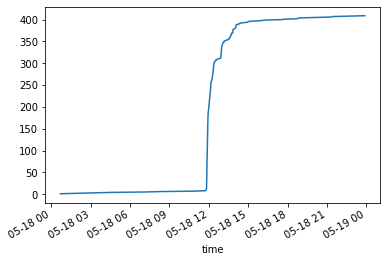

In [11]:
df.cumevents.plot()

<AxesSubplot:xlabel='template_id'>

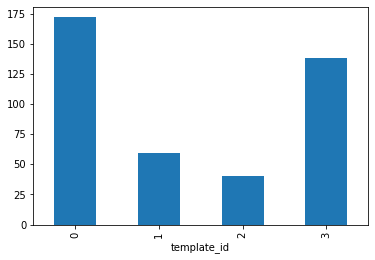

In [12]:
df.groupby('template_id').sum().ones.plot.bar()

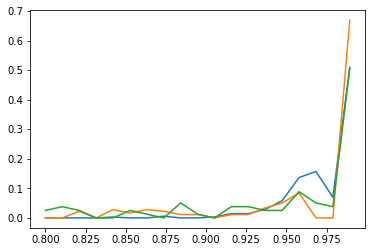

In [13]:
def get_hist(data):
    h, e = np.histogram(data, bins=np.linspace(0.8, 1, 20))
    h = h/h.sum()
    return h, e

fig, ax = plt.subplots()

h, e = get_hist(df[df.template_id==0])
ax.plot(e[:-1], h)

h, e = get_hist(df[df.template_id==1])
ax.plot(e[:-1], h)

h, e = get_hist(df[df.template_id==2])
ax.plot(e[:-1], h)

In [14]:
print('distance between event and first reflection')
UTC('2019-05-18T12:06:05.104Z') - UTC('2019-05-18T12:06:05.628Z')

distance between event and first reflection


-0.524

In [15]:
[1, 2, 3][::-1]

[3, 2, 1]

In [16]:
templates[0][0]

7F.B00.01.GDH | 2019-05-18T11:57:41.507000Z - 2019-05-18T11:57:41.782000Z | 1000.0 Hz, 276 samples

In [18]:
UTC('2019-05-18T11:57:41.782000Z') - UTC('2019-05-18T11:57:41.507000Z')

0.275

In [28]:
detections[0]

{'time': 2019-05-18T00:42:22.171000Z,
 'similarity': 0.84328774092517322,
 'template_id': 1}

In [92]:
window = 0.15

df_traces = pd.DataFrame()

for i, d in enumerate(detections):
    data = day138.copy()
    tr = data.trim(starttime=UTC(d['time']), endtime=UTC(d['time']+window))
    temp_df = pd.DataFrame(
        {
            'times':tr[0].times()
            , 'data':tr[0].data
            , 'id':np.zeros_like(tr[0].data)+i
        })
    df_traces = pd.concat([df_traces, temp_df])

In [93]:
df_traces.describe()

,times,data,id
count,61759.000000,61759.000000,61759.000000
mean,0.075000,0.000071,204.000000
std,0.043589,0.073743,118.068733
min,0.000000,-0.558830,0.000000
25%,0.037000,-0.019965,102.000000
50%,0.075000,-0.000927,204.000000
75%,0.113000,0.012277,306.000000
max,0.150000,0.660691,408.000000


In [94]:
df_traces.head()

,times,data,id
0,0.000,-0.000256,0.0
1,0.001,-0.000335,0.0
2,0.002,-0.000341,0.0
3,0.003,-0.000476,0.0
4,0.004,-0.000445,0.0


In [95]:
def corrmax(tr1, tr2):
    cc = np.correlate(tr1, tr2, 'same')
    return np.max(cc)

corrmax(df_traces[df_traces.id==0].data, df_traces[df_traces.id==2].data)

0.00028475878587043993

In [117]:
ids = df_traces.id.unique()

cc_df = pd.DataFrame()

for id1 in ids:
    for id2 in ids:
        cc = corrmax(df_traces[df_traces.id==id1].data, df_traces[df_traces.id==id2].data)
        cccoef = np.corrcoef(df_traces[df_traces.id==id1].data, df_traces[df_traces.id==id2].data)[0,1]
        temp_df = pd.DataFrame({'id1':[id1], 'id2':[id2], 'cc':[cc], 'cccoef':[cccoef]})
        cc_df = pd.concat([cc_df, temp_df])

In [118]:
cc_df.head()

,id1,id2,cc,cccoef
0,0.0,0.0,0.000296,1.000000
0,0.0,1.0,0.000280,0.891346
0,0.0,2.0,0.000285,0.942873
0,0.0,3.0,0.000254,0.940753
0,0.0,4.0,0.000251,0.959241


In [119]:
cc_df.describe()

,id1,id2,cc,cccoef
count,167281.00000,167281.00000,167281.000000,167281.000000
mean,204.00000,204.00000,0.600089,0.333621
std,118.06813,118.06813,0.508387,0.458566
min,0.00000,0.00000,0.000211,-0.512460
25%,102.00000,102.00000,0.145250,-0.058239
50%,204.00000,204.00000,0.483456,0.161439
75%,306.00000,306.00000,0.984556,0.919774
max,408.00000,408.00000,2.731054,1.000000


In [120]:
cc_df[cc_df.cc>1]

,id1,id2,cc,cccoef
0,9.0,17.0,1.014518,-0.010671
0,9.0,19.0,1.039784,0.027743
0,9.0,21.0,1.024395,0.962906
0,9.0,23.0,1.133990,0.965534
0,9.0,26.0,1.060622,0.959838
...,...,...,...,...
0,406.0,397.0,1.610422,0.981919
0,406.0,400.0,2.184835,0.957443
0,406.0,401.0,1.161259,0.949519
0,406.0,403.0,2.028955,0.990641


In [121]:
detections[400]

{'time': 2019-05-18T17:46:28.275000Z,
 'similarity': 0.96799852346607274,
 'template_id': 0}

In [122]:
day138

1 Trace(s) in Stream:
7F.B00.01.GDH | 2019-05-18T00:00:02.907000Z - 2019-05-19T00:00:01.019000Z | 1000.0 Hz, 86398113 samples

0.9574431455593414

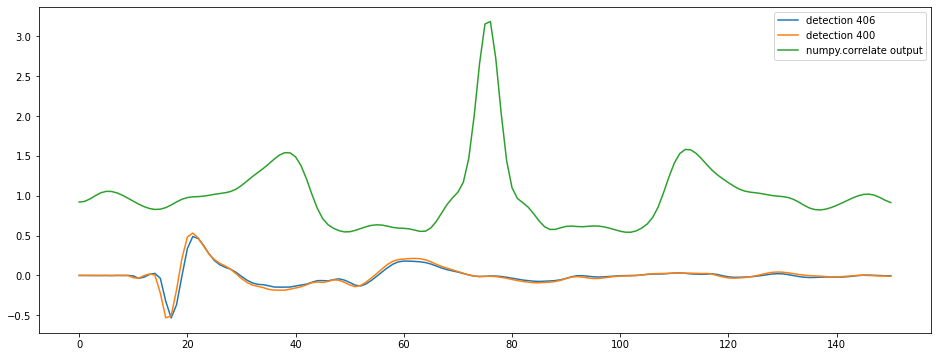

In [123]:
data = day138.copy()
d406 = detections[406]

tr406 = data.trim(starttime=UTC(d406['time']), endtime=UTC(d406['time']+window))

data = day138.copy()
d400 = detections[400]
tr400 = data.trim(starttime=UTC(d400['time']), endtime=UTC(d400['time']+window))

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(tr406[0].data)
ax.plot(tr400[0].data)
ax.plot(np.correlate(tr406[0].data, tr400[0].data, 'same')+1)

ax.legend(['detection 406', 'detection 400', 'numpy.correlate output'])

np.corrcoef(tr406[0].data, tr400[0].data)[0,1]

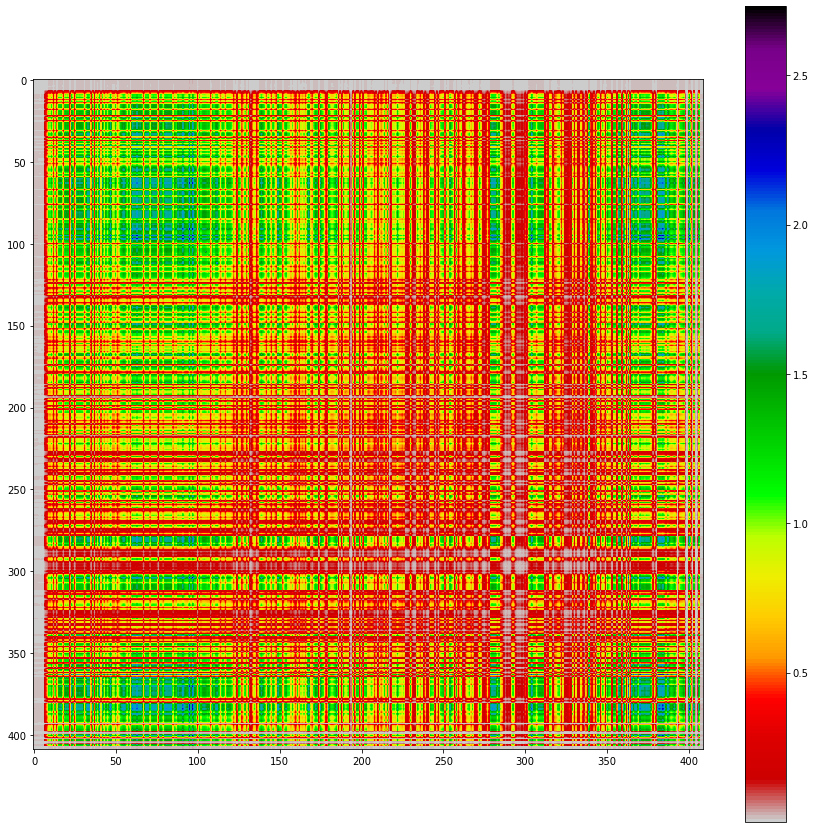

In [124]:
z = cc_df.pivot_table(index='id1', columns='id2', values='cc').values
fig, ax = plt.subplots(figsize=(15, 15))

cbar = ax.imshow(z, cmap='nipy_spectral_r')
fig.colorbar(cbar)

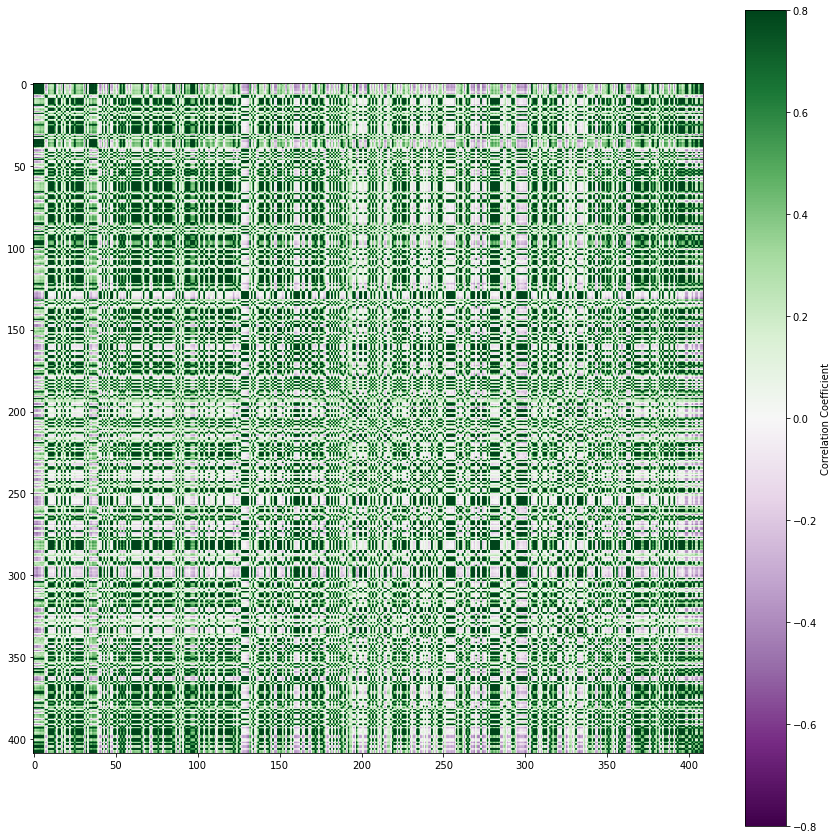

In [131]:
z = cc_df.pivot_table(index='id1', columns='id2', values='cccoef').values
fig, ax = plt.subplots(figsize=(15, 15))

cbar = ax.imshow(z, cmap='PRGn', vmin=-0.8, vmax=0.8)
fig.colorbar(cbar, label='Correlation Coefficient')

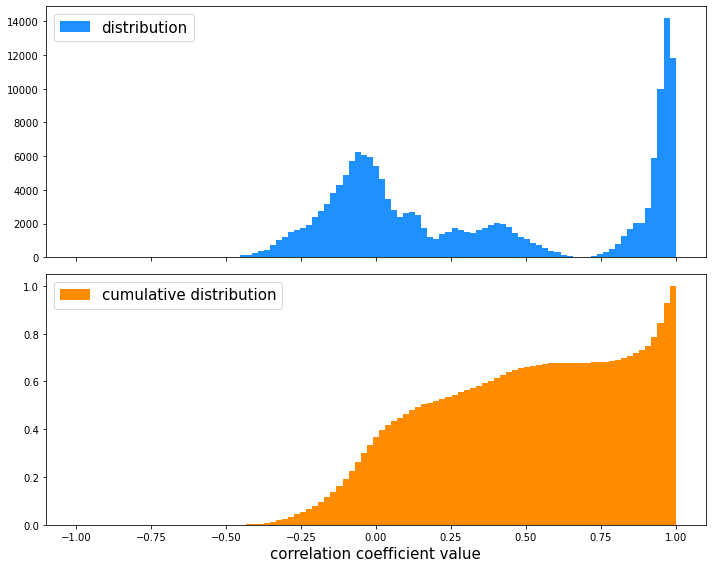

In [165]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
cc_df.cccoef.hist(bins=np.linspace(-1, 1, 100), grid=False, color='dodgerblue', ax=ax)
cc_df.cccoef.hist(bins=np.linspace(-1, 1, 100), grid=False, color='darkorange', ax=ax2, cumulative=True, density=True)
ax2.set_xlabel('correlation coefficient value', fontsize=15)
ax2.legend(['cumulative distribution'], fontsize=15)
ax.legend(['distribution'], fontsize=15)
fig.tight_layout()

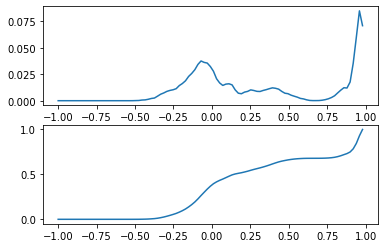

In [159]:
def gethist(data):
    h, e = np.histogram(data, bins=np.linspace(-1, 1, 100))
    h = h/h.sum()
    return h, e

h, e = gethist(cc_df.cccoef)
fig, (ax, ax2) = plt.subplots(2, 1)
ax.plot(e[:-1], h)
ax2.plot(e[:-1], h.cumsum())

<AxesSubplot:xlabel='times'>

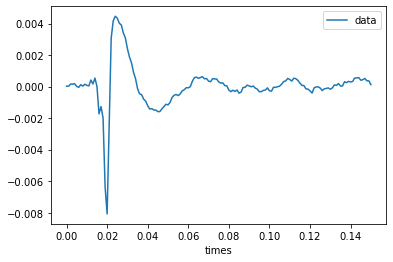

In [105]:
df_traces[df_traces.id==1].plot(x='times', y='data')

<AxesSubplot:xlabel='times'>

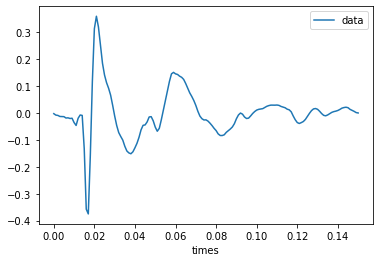

In [106]:
df_traces[df_traces.id==150].plot(x='times', y='data')